In [1]:
##########A few I/O tests with compressed and uncompressed datasets#################
##### test - 2 ######
import numpy as np
import os 
import sys
import h5py
import timeit
# sys.path.append(os.path.realpath("/nfshome/dawit/compression_test/Triforce_CaloML/Loader"))
# import loader
import glob

def file_size(file_path):
    size = os.stat(file_path).st_size
    return size/1000000.0

def timer(test_code, setup, iter_num):
    total_access_time = timeit.Timer(stmt=test_code, 
                                  setup=setup).timeit(number=iter_num)
    return (total_access_time/iter_num)

# def access(file, keys):
#     for key in file.keys():
#         points = np.array(file[key]) 
# #         print(file[key])
#         keys.append(file[key].name.replace('/','')) #store keys for later use. 
#     return keys

def access_epf(file, data_dict, events_per_file):
    features = ['ECAL', 'HCAL', 'pdgID', 'ECAL_E', 'HCAL_E', 'HCAL_ECAL_ERatio', 'energy', 'eta', 'recoEta', 'phi', 'recoPhi', 'openingAngle']
    for feat in features:
        if feat in file.keys():
            data_dict[file.filename+'-'+feat] = np.array(file[feat][:events_per_file])
# added the file.filename+feat fix to hold all arrays at the same time. 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# prepare variables for test
data_dict = {}
time = [] # lsit of tupels (comp_level, epf, file_access_order (1-4), access_time)
iter_num = 1
epf = 0
dataset_path = "/data/shared/LCDLargeWindow/fixedangle/ChPiEscan/"

In [3]:
# make a copy of four test files first to ../test2_decomp_x.h5
for i in range(1,5):
    file_path = dataset_path + "ChPiEscan_2_%d.h5"%i
    out_path = dataset_path + "test2_decomp_%d.h5"%i
    cmd = "h5repack -v %s %s"%(file_path, out_path)
    os.system(cmd) 
print("finished copying four test files")

finished copying four test files


In [4]:
# run tests
for comp_level in [0,3,4]:
    for i in range(1,5):
        decomp_path = os.path.join(dataset_path,
                            'test2_decomp_%d.h5'%i)
            
        out_path = os.path.join(dataset_path,
                            'test2_recomp_%d.h5'%i)
        # recompress file to given compression level
        cmd = "h5repack -v -f GZIP=%d %s %s"%(comp_level, decomp_path, out_path)
        os.system(cmd)
    
    for events in [1000, 2000, 5000, 10000]:
        epf = events
        for i in range(1,5):
            out_path = os.path.join(dataset_path,
                            'test2_recomp_%d.h5'%i)
            comp_file = h5py.File(out_path, 'r')
            
            setup = "from __main__ import comp_file, data_dict, epf, access_epf"
            test_code = "access_epf(comp_file, data_dict, epf)"
            
            # run test and record data 
            tm = (comp_level, epf, i, timer(test_code, setup, iter_num))
            # print stat. 
            print("comp_level:%d , epf:%d , file:%d , time:%.2f"%(tm[0], tm[1], tm[2], tm[3]))
            time.append(tm)
            comp_file.close()
            
        data_dict = {} #clear buffer before next eps test.
        
    # remove recompressed files 
    for i in range(1,5):
        out_path = os.path.join(dataset_path,
                            'test2_recomp_%d.h5'%i) 
        os.system("rm %s"%out_path)  # delete current test2_recomp_x.h5 file. 

comp_level:0 , epf:1000 , file:1 , time:2.16
comp_level:0 , epf:1000 , file:2 , time:2.14
comp_level:0 , epf:1000 , file:3 , time:2.13
comp_level:0 , epf:1000 , file:4 , time:2.13
comp_level:0 , epf:2000 , file:1 , time:4.29
comp_level:0 , epf:2000 , file:2 , time:4.25
comp_level:0 , epf:2000 , file:3 , time:4.24
comp_level:0 , epf:2000 , file:4 , time:4.23
comp_level:0 , epf:5000 , file:1 , time:10.06
comp_level:0 , epf:5000 , file:2 , time:9.99
comp_level:0 , epf:5000 , file:3 , time:9.97
comp_level:0 , epf:5000 , file:4 , time:9.96
comp_level:0 , epf:10000 , file:1 , time:20.14
comp_level:0 , epf:10000 , file:2 , time:19.95
comp_level:0 , epf:10000 , file:3 , time:19.93
comp_level:0 , epf:10000 , file:4 , time:19.88
comp_level:3 , epf:1000 , file:1 , time:2.89
comp_level:3 , epf:1000 , file:2 , time:2.86
comp_level:3 , epf:1000 , file:3 , time:2.86
comp_level:3 , epf:1000 , file:4 , time:2.84
comp_level:3 , epf:2000 , file:1 , time:5.66
comp_level:3 , epf:2000 , file:2 , time:5.64
c

In [5]:
# save result as a numpy array at ../comp_test2_result.npy
result = np.array(time)
np.save(dataset_path+"comp_test2_result.npy", result)

In [6]:
# load the reults numpy array 
result = np.load(dataset_path+"comp_test2_result.npy")
# print(result)

In [7]:
# plot comp-level vs total/file1,2,3,4 access time. 
comp_level = [0,3,4]
epf = [1000, 2000, 5000, 10000]

comp_0 = result[:16]
comp_3 = result[16:32]
comp_4 = result[32:]

def sum_four(lst):
    temp = 0
    summ = []
    for i, res in enumerate(lst):
        if (i % 4) == 3:
            temp += res[3]
            summ.append(temp)
            temp = 0
        else:
            temp += res[3]
    return summ

comp_0_tt = sum_four(comp_0) #total time for different epf values comp_0_tt[0] ~ epf = 1000
comp_3_tt = sum_four(comp_3)
comp_4_tt = sum_four(comp_4)

print(comp_0_tt)
print(comp_3_tt)
print(comp_4_tt)

[8.56956039648503, 17.007253614719957, 39.97289002407342, 79.90220198966563]
[11.445402844343334, 22.624541459139436, 50.836952784564346, 101.33470613369718]
[15.398353574797511, 30.37156966421753, 66.45933774067089, 134.47387276869267]


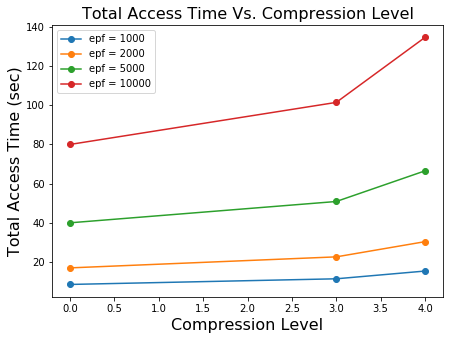

In [9]:
import matplotlib.pyplot as plt

fig_tt = plt.figure(figsize=(7,5))
plt.xlabel('Compression Level', size=16)
plt.ylabel('Total Access Time (sec)', size=16)
plt.title('Total Access Time Vs. Compression Level', size=16)
plt.plot(comp_level, [comp_0_tt[0],comp_3_tt[0],comp_4_tt[0]], '-o', label='epf = 1000')
plt.plot(comp_level, [comp_0_tt[1],comp_3_tt[1],comp_4_tt[1]], '-o', label='epf = 2000')
plt.plot(comp_level, [comp_0_tt[2],comp_3_tt[2],comp_4_tt[2]], '-o', label='epf = 5000')
plt.plot(comp_level, [comp_0_tt[3],comp_3_tt[3],comp_4_tt[3]], '-o', label='epf = 10000')
plt.legend(loc='best')
plt.show()
fig_tt.savefig('ttvcl.png', bbox_inches='tight')
## epf is number of events accessed per file. 

In [ ]:
print(comp_3[8:12])

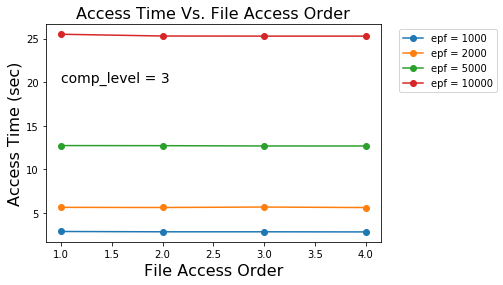

In [10]:
# file access order vs access time for comp_level = 3
order = [1,2,3,4]

fig_order = plt.figure()
plt.xlabel('File Access Order', size=16)
plt.ylabel('Access Time (sec)', size=16)
plt.title('Access Time Vs. File Access Order', size=16)
plt.plot(order, [x[3] for x in comp_3[:4]], '-o', label='epf = 1000')
plt.plot(order, [x[3] for x in comp_3[4:8]], '-o', label='epf = 2000')
plt.plot(order, [x[3] for x in comp_3[8:12]], '-o', label='epf = 5000')
plt.plot(order, [x[3] for x in comp_3[12:16]], '-o', label='epf = 10000')
plt.text(1.0, 20, 'comp_level = 3', size=14)
plt.legend(loc=9, bbox_to_anchor=(1.2, 1))
fig_order.savefig('tvo.png', bbox_inches='tight')
plt.show()
# file access order is the order in which a file is accessed, 
# 1st, 2nd, 3rd and 4th
# looks like the 4th file access is just as fast as the other 3.

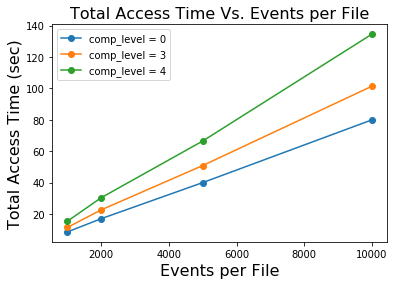

In [11]:
# total access time vs epfs 
fig_epf = plt.figure()
plt.xlabel('Events per File', size=16)
plt.ylabel('Total Access Time (sec)', size=16)
plt.title('Total Access Time Vs. Events per File', size=16)
plt.plot(epf, comp_0_tt, '-o', label='comp_level = 0')
plt.plot(epf, comp_3_tt, '-o', label='comp_level = 3')
plt.plot(epf, comp_4_tt, '-o', label='comp_level = 4')
plt.legend(loc='best')
fig_epf.savefig('ttvepf.png', bbox_inches='tight')
plt.show()
# for epf = 2000 and 1000 no drastic difference between different comp_level values. 